In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [126]:
!ls -lhtr box/frames/

total 8536
-rw-r--r--@ 1 tejaswin.p  1493847943   331K Nov  4  2008 frame_11.png
-rw-r--r--@ 1 tejaswin.p  1493847943   309K Nov  4  2008 frame_10.png
-rw-r--r--@ 1 tejaswin.p  1493847943   313K Nov  4  2008 frame_1.png
-rw-r--r--@ 1 tejaswin.p  1493847943   292K Nov  4  2008 frame_0.png
-rw-r--r--@ 1 tejaswin.p  1493847943   298K Nov  4  2008 frame_7.png
-rw-r--r--@ 1 tejaswin.p  1493847943   297K Nov  4  2008 frame_6.png
-rw-r--r--@ 1 tejaswin.p  1493847943   293K Nov  4  2008 frame_5.png
-rw-r--r--@ 1 tejaswin.p  1493847943   311K Nov  4  2008 frame_4.png
-rw-r--r--@ 1 tejaswin.p  1493847943   310K Nov  4  2008 frame_3.png
-rw-r--r--@ 1 tejaswin.p  1493847943   323K Nov  4  2008 frame_2.png
-rw-r--r--@ 1 tejaswin.p  1493847943   278K Nov  4  2008 frame_13.png
-rw-r--r--@ 1 tejaswin.p  1493847943   326K Nov  4  2008 frame_12.png
-rw-r--r--@ 1 tejaswin.p  1493847943   291K Nov  4  2008 frame_9.png
-rw-r--r--@ 1 tejaswin.p  1493847943   267K Nov  4  2008 frame_8.png


In [127]:
frame = plt.imread('box/frames/frame_0.png')
frame.min(), frame.max()

(0.0627451, 0.99215686)

In [128]:
frame = np.dot(frame[..., :3], [0.333, 0.333, 0.333])

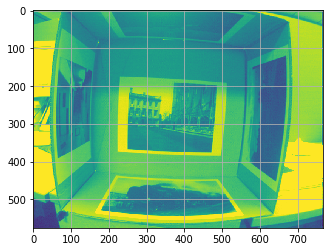

In [129]:
im = plt.imshow(frame)
ax = plt.gca()
ax.grid();

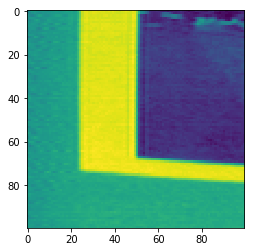

In [130]:
plt.imshow(frame[300:400, 200:300]);

Pixel : 0.8501294206380844
Circle: [0.7835294246077538, 0.5445529682636261, 0.5171294404864312, 0.5092941468358041, 0.654247079372406, 0.8736353015899659, 0.9676588253974915, 0.9754941190481187, 0.9833294126987459, 0.9833294126987459, 0.9754941190481187, 0.9754941190481187, 0.9794117658734323, 0.9872470595240592, 0.9872470595240592, 0.9128117698431015]
Indexd: [0.78352942 0.54455297 0.51712944 0.50929415 0.65424708 0.8736353
 0.96765883 0.97549412 0.98332941 0.98332941 0.97549412 0.97549412
 0.97941177 0.98724706 0.98724706 0.91281177]
True


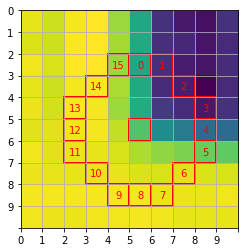

In [137]:
## Approx location -- (365, 250)
section = frame[300:400, 200:300][62:72, 45:55]

im = plt.imshow(section)
ax = plt.gca()

ax.set_xticks(np.arange(-0.5, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))

ax.set_yticks(np.arange(-0.5, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))

ax.grid();

center = patches.Rectangle((5-0.5,5-0.5),1,1,linewidth=2,edgecolor='r',facecolor='none')
ax.add_patch(center)

v_pix = section[5, 5]
v_xs = []
for num, (ox, oy) in enumerate(circle_mask):
    p = patches.Rectangle((5+ox-0.5, 5+oy-0.5), 1, 1, linewidth=2, edgecolor='red', facecolor='none')
    v_xs.append(section[5+ox, 5+oy])
    ax.add_patch(p)
    ax.text(5+oy, 5+ox, str(num), ha='center',va='center',color='red')
    
_pixmask = circle_mask + np.array([5, 5])
print "Pixel :", v_pix
print "Circle:", v_xs
print "Indexd:", section[_pixmask[:, 0], _pixmask[:, 1]]
print np.allclose(v_xs, section[_pixmask[:, 0], _pixmask[:, 1]])

Q1. What about the edges which don't have neighbouring pixels?

Since it's only 16 pixels, I guess we can ignore those for now ...

In [132]:
def weak_test(p, compass, t):
    # Higher means brigher.
    if sum([v>=(p+t) for v in compass]) >= 3:  # At least 3 are brighter.
        return True
    elif sum([v<=(p-t) for v in compass]) >= 3:  # At least 3 are darker.
        return True
    else:
        return False

In [133]:
import pdb

In [134]:
def segment_test(p, circle, t):
    vector = []
    for x in circle:
        if x <= (p-t):
            vector.append(-1)
        elif (p-t) < x < (p+t):
            vector.append(0)
        else:
            vector.append(1)

    extended = np.tile(circle, 2)

    for i in range(circle.shape[0]):
        subset = extended[i:i+12]
        if np.alltrue(subset > (p+t)) or np.alltrue(subset < (p-t)):
            return True, vector
        
    return False, vector

In [180]:
from tqdm import tqdm_notebook
import random

In [184]:
# circle_mask = np.array([
#     [ 0, -3],
#    [ 1, -3],
#    [ 2, -2],
#    [ 3, -1],
#    [ 3,  0],
#    [ 3,  1],
#    [ 2,  2],
#    [ 1,  3],
#    [ 0,  3],
#     [-1,  3],
#    [-2,  2],
#    [-3,  1],
#    [-3,  0],
#    [-3, -1],
#    [-2, -2],
#    [-1, -3]
# ])
circle_mask = np.array([
    [-3, 0],
    [-3, 1],
    [-2, 2],
    [-1, 3],
    [0, 3],
    
    [1, 3],
    [2, 2],
    [3, 1],
    [3, 0],
    
    [3, -1],
    [2, -2],
    [1, -3],
    [0, -3],
    
    [-1, -3],
    [-2, -2],
    [-3, -1]
])

compass_mask = [0, 4, 8, 12]

threshold = 0.07

rows, cols = frame.shape[0], frame.shape[1]
potentials = []
trainX, trainY = [], []
for i in tqdm_notebook(range(3, rows - 3)):
    for j in range(3, cols - 3):
        
        pmask = circle_mask + np.array([[i, j]])
        xvals = frame[pmask[:, 0], pmask[:, 1]]
        # compvals = xvals[compass_mask]
        # if weak_test(pval, compvals, threshold):
        
        pval = frame[i, j]
        
        successful, vector = segment_test(pval, xvals, threshold)
        if successful is True:
            potentials.append([i, j])
            trainX.append(vector)
            trainY.append(1)  # This is a corner.
        else:
            if random.random() < 0.3:  # Don't take all of them... sample about 30%
                trainX.append(vector)
                trainY.append(0)

In [185]:
trainX = np.array(trainX)
trainY = np.array(trainY)

In [186]:
len(potentials), len(trainX)

(1064, 130344)

In [195]:
rows * cols

442368

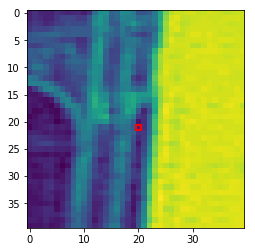

In [178]:
cx, cy = random.choice(potentials)
cpatch = frame[cx-20:cx+20, cy-20:cy+20]
crect = patches.Rectangle((20-0.5, 20+0.5), 1, 1, linewidth=2,edgecolor='r',facecolor='none')
im = plt.imshow(cpatch)
ax = plt.gca()
ax.add_patch(crect);

287 478


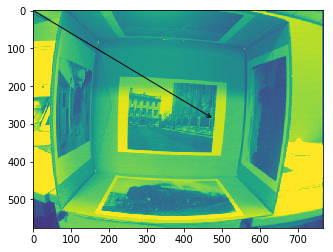

In [179]:
print cx,cy
im = plt.imshow(frame)
ax = plt.gca()
ax.annotate("", xy=(cy, cx), xytext=(0, 0), arrowprops=dict(arrowstyle="->",connectionstyle="arc3"));

# id3 code + sample data

In [116]:
ball_data, ball_target = [], []
import csv
with open('/Users/tejaswin.p/Downloads/id3_test_data - Sheet1.csv') as fp:
    reader = csv.DictReader(fp)
    ball_columns = reader.fieldnames
    for row in reader:
        ball_data.append([row[c] for c in ball_columns[1:-1]])
        ball_target.append(row[ball_columns[-1]])
        
ball_target = [True if x=='Yes' else False for x in ball_target]
ball_names = ball_columns[1:-1]

In [117]:
def calc_truth_entropy(numtrue, numtotal):
    if (numtrue == numtotal) or (numtrue == 0):
        return 0
    
    p = numtrue*1.0/numtotal
    return -p*np.log2(p) - (1-p)*np.log2(1-p)

def check_all_same(arr):
    if np.alltrue(arr) or np.alltrue(arr == False):
        return True
    else:
        return False

In [118]:
from collections import Counter
import pdb

In [187]:
def find_splits(x, y, tree, remainfeats):
    if check_all_same(y):
        print "Found a leaf!", tree
        return y[0]
    else:        
        # Find the `current`(parent) entropy ...
        numtrue = int(np.sum(y))
        numtotal = y.shape[0]
        
        parent_entropy = calc_truth_entropy(numtrue, numtotal)
        
        # Find entropy of all remaining features to calculate InfoGain ...
        infogain = {}
        metadata = {}
        for ix in remainfeats:  # `f_ix` == feature_index
            val_count = Counter(x[:, ix])
            true_count = {k:int(np.sum(y[x[:, ix]==k] == True)) for k in val_count}
            
            metadata[ix] = val_count
            
            feature_entropy = 0
            for key in val_count:
                knum = val_count[key]
                feature_entropy += float(knum)/numtotal * calc_truth_entropy(true_count[key], knum)
                
            infogain[ix] = parent_entropy - feature_entropy
            
        # Get the highest gaining feature ...
        split = sorted(infogain.items(), key=lambda x:x[1])[-1][0]
        fvals = metadata[split]
        
        # Split the data into subsets for different values of the `split` variable ...
        for v in fvals:
            mask = x[:, split]==v
            subset_x = x[mask]
            subset_y = y[mask]
            
            key = (split, v)
            
            if check_all_same(subset_y):
                tree[key] = subset_y[0]
                print "Found a leaf!", tree
            else:
                tree[key] = find_splits(subset_x, subset_y, {}, remainfeats-{split})
            
    return tree

In [188]:
_bdnp = np.array(ball_data)
_btnp = np.array(ball_target)

In [189]:
initfeats = set(range(_bdnp.shape[1]))
inittree = {}
find_splits(_bdnp, _btnp, inittree, initfeats)

Found a leaf! {(0, 'Overcast'): True}
Found a leaf! {(2, 'High'): False}
Found a leaf! {(2, 'Normal'): True, (2, 'High'): False}
Found a leaf! {(3, 'Strong'): False}
Found a leaf! {(3, 'Weak'): True, (3, 'Strong'): False}


{(0, 'Overcast'): True,
 (0, 'Rain'): {(3, 'Strong'): False, (3, 'Weak'): True},
 (0, 'Sunny'): {(2, 'High'): False, (2, 'Normal'): True}}

In [123]:
## Traverse a tree ...
def traverse(t, n):
    for k,v in t.items():
        column = ball_names[k[0]]
        if isinstance(v, dict):
            # go deeper ...
            n[(column, k[1])] = traverse(v, {})
        else:
            n[(column, k[1])] = v
            
    return n

In [122]:
isinstance(inittree, dict)

True

In [124]:
inittree

{(0, 'Overcast'): True,
 (0, 'Rain'): {(3, 'Strong'): False, (3, 'Weak'): True},
 (0, 'Sunny'): {(2, 'High'): False, (2, 'Normal'): True}}

In [125]:
traverse(inittree, {})

{('Outlook', 'Overcast'): True,
 ('Outlook', 'Rain'): {('Wind', 'Strong'): False, ('Wind', 'Weak'): True},
 ('Outlook', 'Sunny'): {('Humidity', 'High'): False,
  ('Humidity', 'Normal'): True}}

# id3 on frame ...

In [190]:
trainX.shape, trainY.shape

((130344, 16), (130344,))

In [193]:
fastfeats = set(range(trainX.shape[1]))

fasttree = find_splits(x=trainX, y=trainY, tree={}, remainfeats=fastfeats)

Found a leaf! {(14, 0): 0}
Found a leaf! {(8, 0): 0}
Found a leaf! {(12, 0): 0}
Found a leaf! {(15, 0): 0}
Found a leaf! {(10, 0): 0}
Found a leaf! {(6, 0): 0}
Found a leaf! {(0, 0): 0}
Found a leaf! {(11, 0): 0}
Found a leaf! {(9, 0): 0}
Found a leaf! {(1, 0): 0}
Found a leaf! {(1, 0): 0, (1, 1): 1}
Found a leaf! {(5, 1): 1, (5, 0): {(1, 0): 0, (1, 1): 1}}
Found a leaf! {(6, 1): {(0, 1): {(11, 0): 0, (11, 1): {(9, 0): 0, (9, 1): {(5, 1): 1, (5, 0): {(1, 0): 0, (1, 1): 1}}}}, (0, 0): 0}, (6, 0): 0, (6, -1): 0}
Found a leaf! {(7, 0): 0}
Found a leaf! {(7, 0): 0, (7, 1): 1}
Found a leaf! {(2, 0): {(6, 1): {(0, 1): {(11, 0): 0, (11, 1): {(9, 0): 0, (9, 1): {(5, 1): 1, (5, 0): {(1, 0): 0, (1, 1): 1}}}}, (0, 0): 0}, (6, 0): 0, (6, -1): 0}, (2, -1): 0, (2, 1): {(7, 0): 0, (7, 1): 1}}
Found a leaf! {(11, 0): 0}
Found a leaf! {(11, 0): 0, (11, 1): 1}
Found a leaf! {(4, 1): {(11, 0): 0, (11, 1): 1}, (4, -1): 0, (4, 0): {(2, 0): {(6, 1): {(0, 1): {(11, 0): 0, (11, 1): {(9, 0): 0, (9, 1): {(5, 1)

Found a leaf! {(14, 0): 0}
Found a leaf! {(14, 1): 0, (14, 0): 0}
Found a leaf! {(6, 0): 0}
Found a leaf! {(6, 1): 0, (6, 0): 0}
Found a leaf! {(0, 0): 0}
Found a leaf! {(0, 1): 0, (0, 0): 0}
Found a leaf! {(8, 0): 0}
Found a leaf! {(5, 0): 0}
Found a leaf! {(5, -1): 1, (5, 0): 0}
Found a leaf! {(12, 1): 0, (12, 0): {(8, -1): {(5, -1): 1, (5, 0): 0}, (8, 0): 0}}
Found a leaf! {(1, 0): 0}
Found a leaf! {(5, 0): 0}
Found a leaf! {(11, 0): 0}
Found a leaf! {(15, 0): 0}
Found a leaf! {(15, -1): 1, (15, 0): 0}
Found a leaf! {(7, 0): {(11, 0): 0, (11, -1): {(15, -1): 1, (15, 0): 0}}, (7, 1): 1}
Found a leaf! {(7, -1): 1, (7, 0): {(11, 0): 0, (11, -1): {(15, -1): 1, (15, 0): 0}}, (7, 1): 1}
Found a leaf! {(9, 0): 0}
Found a leaf! {(9, 0): 0, (9, 1): 0}
Found a leaf! {(15, 0): 0}
Found a leaf! {(15, -1): 1, (15, 0): 0}
Found a leaf! {(0, 0): 0}
Found a leaf! {(7, 0): 0}
Found a leaf! {(2, 0): 0}
Found a leaf! {(2, 0): 0, (2, 1): 1}
Found a leaf! {(15, 0): 0}
Found a leaf! {(11, 0): 0}
Found a 